# Truncating eigenvalues

In [1]:
import sandy

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Processing U-235 with ERRORR

The ENDF/B-8.0 file for U-235 was selected since the stored covariance matrix contains a large negative eigenvalue coming from the cross correlation between the fission and capture cross sections.

In [4]:
err = 0.1  # RECONR xs reconstruction tolerance (poor, but it should work)

# ERRROR parameters
relative = True  # relative covariance matrix
mt = [18, 102]  # considered reactions
ek_errorr = [2e-5, 5.4e-1, 2.26033e1, 2.03468e3, 6.73795e4, 4.97871e5, 2.23130e6, 1.96403e7]  # energy groups in eV
iwt_errorr = 2  # constant

In [5]:
tape = sandy.get_endf6_file("endfb_80", "xs", 922350)
errorr = tape.get_errorr(
    err=err, relative=relative, mt=mt,
    ek_errorr=ek_errorr, iwt_errorr=iwt_errorr,
    mubar=False, chi=False, nubar=False,
)

## Extracting covariance and plotting eigenvalues

In [6]:
C = errorr.get_cov()

In [7]:
Ecov, Vcov = C.get_eig()
corr = C.get_corr()
Ecorr, Vcorr = corr.get_eig()

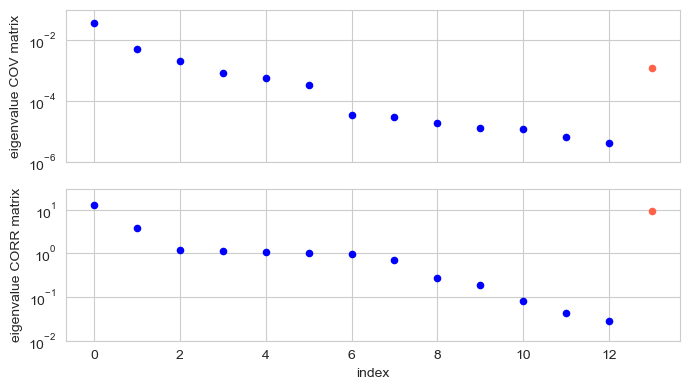

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(7, 4), sharex=True, dpi=100)

ax = axs[0]
eigs = Ecov.sort_values(ascending=False).reset_index(drop=True).reset_index()
eigs["ABS"] = eigs.EIG.abs()
eigs[eigs.EIG >= 0].plot(kind="scatter", x="index", y="ABS", ax=ax, logy=True, color="blue")
eigs[eigs.EIG <= 0].plot(kind="scatter", x="index", y="ABS", ax=ax, logy=True, color="tomato")
ax.set_ylabel("eigenvalue COV matrix")
ax.set_ylim([1e-6, 1e-1])

ax = axs[1]
eigs = Ecorr.sort_values(ascending=False).reset_index(drop=True).reset_index()
eigs["ABS"] = eigs.EIG.abs()
eigs[eigs.EIG >= 0].plot(kind="scatter", x="index", y="ABS", ax=ax, logy=True, color="blue")
eigs[eigs.EIG <= 0].plot(kind="scatter", x="index", y="ABS", ax=ax, logy=True, color="tomato")
ax.set_ylabel("eigenvalue CORR matrix")
ax.set_ylim([1e-2, 3e1])

fig.tight_layout()

# Eigenvalue truncation

A `tolerance=0` was set to truncate all eigenvalues `<0`. These eigenvalues are replaced by zeros.

Then, the covariance matrix can be reconstructed from its __modified__ eigenvalues and original eigenvectors as:

$$
\widetilde{\mathbf{C}} = \mathbf{V} \widetilde{\mathbf{E}} \mathbf{V}^T 
$$

In [9]:
Ecov, Vcov = C.get_eig(tolerance=0)
C_ = sandy.CategoryCov(np.diag(Ecov.values)).sandwich(Vcov.T.values)
C_.data.index = C_.data.columns = C.data.index
corr_ = C_.get_corr()

The correlation matrix shows different correlations in the low energy region for fission and between the low energy region for fission and the high energy region for capture.

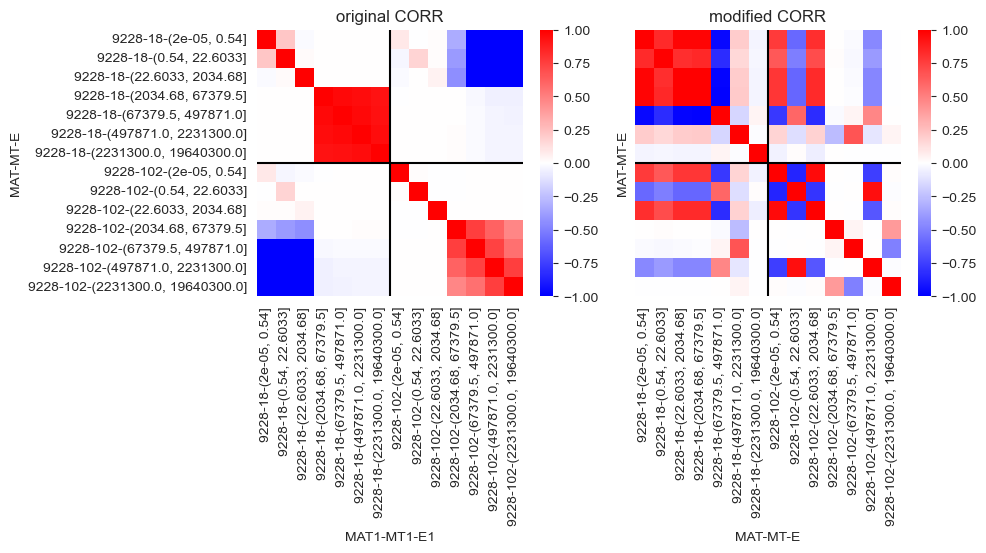

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, dpi=100)

ax = axs[0]
ax.set_aspect("equal")
sns.heatmap(corr.data, ax=ax, cmap='bwr', vmin=-1, vmax=1)
ax.axhline(7, color='black')
ax.axvline(7, color='black')
ax.set_title("original CORR")

ax = axs[1]
ax.set_aspect("equal")
sns.heatmap(corr_.data, ax=ax, cmap='bwr', vmin=-1, vmax=1)
ax.axhline(7, color='black')
ax.axvline(7, color='black')
ax.set_title("modified CORR")

fig.tight_layout()

The standard deviation is also affected.

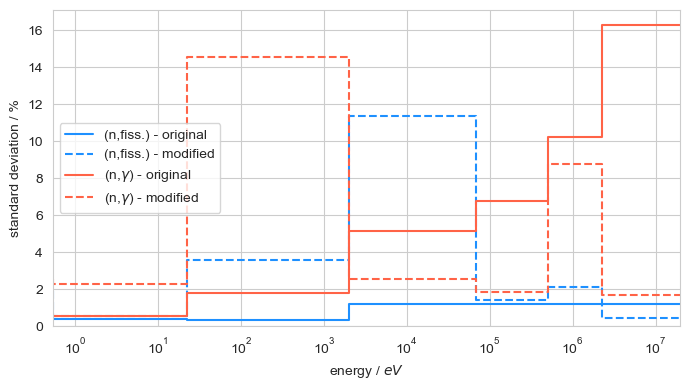

In [12]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=100)

std = C.get_std().reset_index().pivot_table(index="E", columns="MT", values="STD").multiply(100)
std.index = std.index.right
std_ = C_.get_std().reset_index().pivot_table(index="E", columns="MT", values="STD").multiply(100)
std_.index = std_.index.right

std[18].plot(ax=ax, logx=True, drawstyle="steps-pre", label="(n,fiss.) - original", color="dodgerblue")
std_[18].plot(ax=ax, logx=True, drawstyle="steps-pre", label="(n,fiss.) - modified", color="dodgerblue", linestyle="--")

std[102].plot(ax=ax, logx=True, drawstyle="steps-pre", label="(n,$\gamma$) - original", color="tomato")
std_[102].plot(ax=ax, logx=True, drawstyle="steps-pre", label="(n,$\gamma$) - modified", color="tomato", linestyle="--")

ax.legend()
ax.set_ylim((0, None))
ax.set_xlim((std.index[0], std.index[-1]))
ax.set_ylabel("standard deviation / %")
ax.set_xlabel("energy / $eV$")

fig.tight_layout()